**Métodos de Previsão Aplicados @ MADSAD - CBS|ISCAC (2022/2023)**

**Trabalho - Parte 3 (35%)**

*Entregáveis:* 
1. este *notebook* resolvido (com **código e comentários** para as tarefas 1 e 2)

*Submissão* até **09/05/2023 às 23:59** no InforEstudante

Grupo #:
* Luís Coimbra 2018073846
* Mário Simão 2022120561

# _1. Dados

* *city:* Munich
* *station:* Kreuther
* *ficheiro:* `data_2019-01-01T00_00_00-2022-01-31T23_45_00_Kreuther.csv`

*Fonte:* [Open Bicycle’s Data](https://www.bicycle-data.de/bicycles-data/)

Nesta secção do *notebook* não há tarefas a realizar. Serve apenas para familiarização com o conjunto de dados a trabalhar nesta terceira parte do trabalho.

Com esse objetivo, são já disponibilizadas as linhas de comando que é necessário executar, não sendo, no entanto, acompanhadas por comentários aos *outputs* obtidos.

**IMPORTANTE:** Verificar o `file_path` (na segunda célula de código) que tem a localização do ficheiro de dados e, se necessário, corrigir.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/MADSAD/MPA/Trabalho/data_2019-01-01T00_00_00-2022-01-31T23_45_00_Kreuther.csv'

In [ ]:
import pandas as pd

In [ ]:
df_raw = pd.read_csv(file_path)

In [ ]:
df = (df_raw
      .filter(['start','bothDirections'])
      .assign(start = pd.to_datetime(df_raw.start))
      .set_index('start')
      .asfreq('15min')
      .query('"2021-06-01" <= index < "2021-12-01"')
      .resample('D')
      .sum()
)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2021-06-01 to 2021-11-30
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bothDirections  183 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


In [ ]:
df.head()

,bothDirections
start,
2021-06-01,1125.0
2021-06-02,1177.0
2021-06-03,829.0
2021-06-04,703.0
2021-06-05,648.0


In [ ]:
df.tail()

,bothDirections
start,
2021-11-26,518.0
2021-11-27,263.0
2021-11-28,129.0
2021-11-29,501.0
2021-11-30,372.0


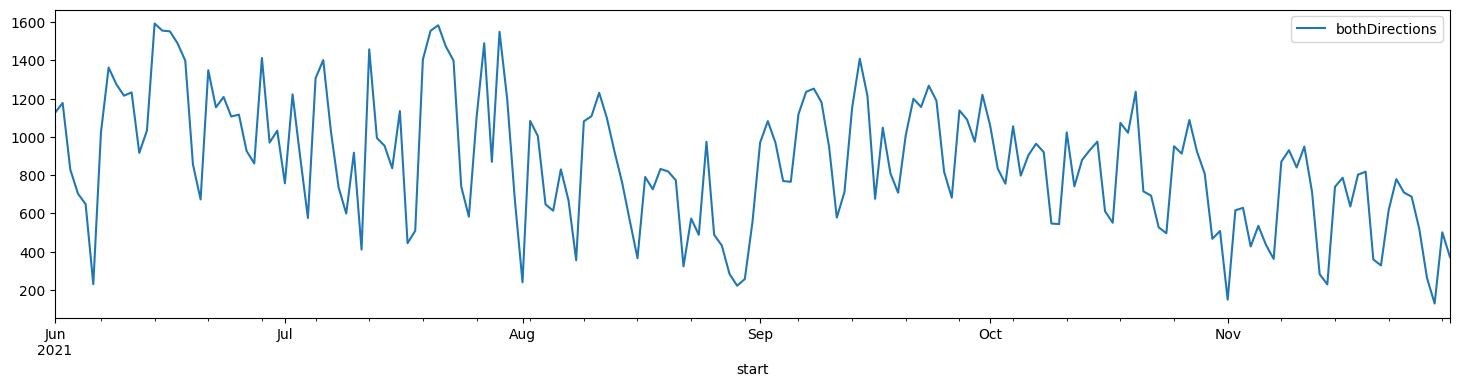

In [ ]:
df.plot(figsize=(18,4));

No erro ha 2 opçoes(aditiva e multiplicativo) , na tendencia ha 5 ( nula,aditiva,aditiva amortecida,multiplicativa,multiplicativa amortecida) na sazonalidade ha 3 opções (nula,aditiva,multiplicativa)



# _2. Livraria do Python para previsão

A sugestão é que seja usada a livraria [StatsForecast](https://nixtla.github.io/statsforecast/), mas pode ser usada qualquer uma desde que recomendada em [Python implementations of time series forecasting and anomaly detection](https://robjhyndman.com/hyndsight/python_time_series.html) by Rob J Hyndman (2022-10-07).

In [ ]:
%%capture
!pip install statsforecast

In [ ]:
%%capture
!pip install datasetsforecast

In [ ]:
from statsforecast import StatsForecast

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from statsforecast.models import SeasonalNaive , AutoARIMA , AutoETS
# acrescentar os modelos

#https://nixtla.github.io/statsforecast/models.html

In [ ]:
from datasetsforecast.losses import rmse,mae,mape
 #acrescentar os medidas a usar

In [ ]:
Y_df = (df
       .reset_index() #tirei os indices porque precisamos da coluna ds com as datas
       .rename(columns={'index': 'ds', 'sales': 'y'}) # mudar nome das colunas
       .assign(unique_id = 'PT')   # por uma coluna nova 
       .filter(['unique_id', 'ds', 'y'])
        )
Y_df

,unique_id
0,PT
1,PT
2,PT
3,PT
4,PT
...,...
178,PT
179,PT
180,PT
181,PT


# _3. Previsão para as duas semanas seguintes 

> **Tarefa 1:** Fazer a previsão para todos os catorze dias entre `2021-12-01` a `2021-12-14`, usando o melhor método, **escolhido com base nas melhores práticas**, entre:
* um elementar (escolher mesmo só um método elementar para testar), 
* um ETS (em versão de seleção automática) e
* um ARIMA (em versão de seleção automática).

Aqui começa-se por transformar o dataset de forma a ser mais fácil de o trabalhar:

In [ ]:
Y_df = (df
        .reset_index()
        .rename(columns={'start' : 'ds', 'bothDirections' : 'y'})
        .assign(unique_id='KRE')
        .filter(['unique_id', 'ds', 'y']))
        

In [ ]:
StatsForecast.plot(Y_df)

In [ ]:
display(Y_df)

,unique_id,ds,y
0,KRE,2021-06-01,1125.0
1,KRE,2021-06-02,1177.0
2,KRE,2021-06-03,829.0
3,KRE,2021-06-04,703.0
4,KRE,2021-06-05,648.0
...,...,...,...
178,KRE,2021-11-26,518.0
179,KRE,2021-11-27,263.0
180,KRE,2021-11-28,129.0
181,KRE,2021-11-29,501.0


**Para esta primeira tarefa pretende-se utilizar a mesma origem para treinar 14 horizontes diferentes**

Utilizámos os modelos descritos,e podíamos ter experimentado muitos mais, e de seguida trocou-se para frequência diária:

In [ ]:

model_list = [SeasonalNaive(season_length=7, alias = 'SN'), 
              AutoARIMA(season_length=7, trace = True, alias = 'autoARIMA'),
              AutoARIMA(season_length=7, d=1, trace = True, alias = 'ARIMA_d1'),
              AutoETS(season_length=7, alias='AutoETS'),
              AutoETS(season_length=7, model='ZAA', damped=True,alias='ZAdA') 
              ]


sf = StatsForecast(df=Y_df, models=model_list, freq='D')



Aqui o h=14 pois estamos a prever 14 dias, com um intervalo de confiança de 90%:

In [ ]:
forecasts_df = sf.forecast(h=14, level=[90])


ARIMA(2,0,2)(1,1,1)[7]                   :2410.0678558677537

ARIMA(0,0,0)(0,1,0)[7]                   :2520.2707373531894

ARIMA(1,0,0)(1,1,0)[7]                   :2444.6449809509504

ARIMA(0,0,1)(0,1,1)[7]                   :2441.239654949846

ARIMA(2,0,2)(0,1,1)[7]                   :2411.1024776846025

ARIMA(2,0,2)(1,1,0)[7]                   :2440.9707309239984

ARIMA(2,0,2)(2,1,1)[7]                   :2412.3060027921024

ARIMA(2,0,2)(1,1,2)[7]                   :2413.0653566394863

ARIMA(2,0,2)(0,1,0)[7]                   :2474.6090332656536

ARIMA(2,0,2)(0,1,2)[7]                   :2411.6166667693824

ARIMA(2,0,2)(2,1,0)[7]                   :2435.1497815856374

ARIMA(2,0,2)(2,1,2)[7]                   :2414.028439685322

ARIMA(1,0,2)(1,1,1)[7]                   :2418.0874661463213

ARIMA(2,0,1)(1,1,1)[7]                   :2410.4880059178704

ARIMA(3,0,2)(1,1,1)[7]                   :2412.122566271308

ARIMA(2,0,3)(1,1,1)[7]                   :2412.3150351066492

ARIMA(1,0,

In [ ]:
display(forecasts_df)

,ds,SN,SN-lo-90,SN-hi-90,autoARIMA,autoARIMA-lo-90,autoARIMA-hi-90,ARIMA_d1,ARIMA_d1-lo-90,ARIMA_d1-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90,ZAdA,ZAdA-lo-90,ZAdA-hi-90
unique_id,,,,,,,,,,,,,,,,
KRE,2021-12-01,709.0,-9.906333,1427.906372,565.868225,206.171021,925.565491,484.036621,119.597252,848.476013,496.426056,144.562515,848.289612,495.044617,139.470154,850.619080
KRE,2021-12-02,687.0,-31.906332,1405.906372,584.646484,190.639328,978.653564,436.179901,33.244469,839.115295,426.689850,42.202686,811.177002,418.080994,28.442423,807.719604
KRE,2021-12-03,518.0,-200.906326,1236.906372,574.794067,157.192627,992.395508,381.565796,-56.495686,819.627258,405.858917,-8.692396,820.410217,399.109253,-22.579729,820.798218
KRE,2021-12-04,263.0,-455.906342,981.906311,295.742798,-132.256088,723.741638,83.823189,-386.749603,554.395996,124.292259,-318.285675,566.870178,111.317261,-340.705963,563.340454
KRE,2021-12-05,129.0,-589.906311,847.906311,263.418671,-172.059402,698.896729,2.032589,-498.946106,503.011292,-5.819431,-474.751892,463.113007,-19.245016,-500.110718,461.620697
KRE,2021-12-06,501.0,-217.906326,1219.906372,628.624695,189.728439,1067.520996,372.753143,-156.888748,902.395081,462.106689,-31.775949,955.989319,446.567627,-61.825554,954.960815
KRE,2021-12-07,372.0,-346.906342,1090.906372,681.100159,239.729431,1122.470947,411.459473,-145.375504,968.294434,501.619446,-16.012167,1019.251038,486.428253,-48.321030,1021.177490
KRE,2021-12-08,709.0,-9.906333,1427.906372,728.194885,270.481140,1185.908569,426.881714,-173.352768,1027.116211,496.426056,-43.911716,1036.763794,483.472015,-76.581512,1043.525513
KRE,2021-12-09,687.0,-31.906332,1405.906372,723.134216,260.535431,1185.732910,378.627838,-252.951477,1010.207153,426.689850,-135.437653,988.817383,408.822906,-175.584183,993.230042


Nos passos anteriores utilizámos dados antigos para fazer previsões para o futuro.
No entanto , **para sabermos se de facto a sua precisão está correta , precisamos de aplicar cross-validation**.

## **2-Avaliar a performance do modelo**

### **Cross Validation**
Com dados de séries temporais , a cross validation é realizada definindo uma janela deslizante ao longo dos dados , consequentemente prevendo os dados do periodo seguinte.

Vantagens:
- Permite chega a uma melhor estimativa das capacidades preditivas do nosso modelo ao longo de varias instâncias temporais;
- Mantém os dados do conjunto de treino contínuo ( requirido pelos modelos)


O n_windows=1 faz com que número de observações será dividido em várias janelas, e o modelo será ajustado separadamente para cada janela, neste caso usou-se 1 para fazer para todos os dias, mas também se podia usar 7 para ser semanal:

In [ ]:
crossvalidation_df = sf.cross_validation(
    df = Y_df,         
    h = 14,            
    n_windows = 1)    
crossvalidation_df


ARIMA(2,0,2)(1,1,1)[7]                   :2228.3132071605164

ARIMA(0,0,0)(0,1,0)[7]                   :2329.0894586522295

ARIMA(1,0,0)(1,1,0)[7]                   :2259.813008576948

ARIMA(0,0,1)(0,1,1)[7]                   :2253.72118848847

ARIMA(2,0,2)(0,1,1)[7]                   :2228.737165953388

ARIMA(2,0,2)(1,1,0)[7]                   :2256.380164099857

ARIMA(2,0,2)(2,1,1)[7]                   :2230.0465913029525

ARIMA(2,0,2)(1,1,2)[7]                   :2231.212814201296

ARIMA(2,0,2)(0,1,0)[7]                   :2287.8986609405833

ARIMA(2,0,2)(0,1,2)[7]                   :2229.615623179806

ARIMA(2,0,2)(2,1,0)[7]                   :2252.0170957190453

ARIMA(2,0,2)(2,1,2)[7]                   :2231.7859337274767

ARIMA(1,0,2)(1,1,1)[7]                   :2233.175818348929

ARIMA(2,0,1)(1,1,1)[7]                   :2228.179332461289

ARIMA(2,0,1)(0,1,1)[7]                   :2229.3431234809236

ARIMA(2,0,1)(1,1,0)[7]                   :2254.3595328938213

ARIMA(2,0,1)(2,1

,ds,cutoff,y,SN,autoARIMA,ARIMA_d1,AutoETS,ZAdA
unique_id,,,,,,,,
KRE,2021-11-17,2021-11-16,636.0,840.0,870.486206,794.480835,776.286987,777.263123
KRE,2021-11-18,2021-11-16,802.0,949.0,845.126343,713.112915,693.107361,690.034729
KRE,2021-11-19,2021-11-16,818.0,713.0,774.971558,667.322571,674.423889,676.435303
KRE,2021-11-20,2021-11-16,359.0,282.0,469.339783,382.886597,397.400116,394.318726
KRE,2021-11-21,2021-11-16,328.0,229.0,418.787170,303.869019,262.338776,259.888580
KRE,2021-11-22,2021-11-16,617.0,739.0,803.901123,688.450989,738.433105,737.496155
KRE,2021-11-23,2021-11-16,779.0,786.0,865.299927,741.092773,779.122803,781.431458
KRE,2021-11-24,2021-11-16,709.0,840.0,926.057861,770.426636,776.286987,776.904358
KRE,2021-11-25,2021-11-16,687.0,949.0,856.156189,686.617371,693.107361,689.739563


- **ds** consiste na série temporal que foi avaliada;
- O **cutoff** consiste no dia 16-11-2021 porque pegou 14 dias antes do ulltimo valor de dado ( 30-11-2021) 

IMPORTANTE : cutoff , mantem-se porque é mesma origem com horizontes diferentes;
- **y** é o true value;
- Depois vem os resultados dos respetivos modelos.


Agora que temos os resultados de cada modelo , vamos **avaliar a sua perfomance utilizando métricas de erros comuns.**

### **Avaliar a perfomance utilizando métricas de erros comuns ( RMSE , MAE , MAPE)**

As métricas de erros comuns são utilizadas para avaliar a precisão dos modelos de previsão.

---





 **RMSE (Root Mean Squared Error):** O RMSE é uma métrica que calcula a **raiz quadrada da média** dos erros quadráticos.

O RMSE é uma medida de erro que fornece a magnitude média do erro entre as previsões e as observações, sendo que valores mais baixos indicam melhor precisão.


---

**MAE (Mean Absolute Error):** O MAE é uma métrica que calcula a **média** das diferenças absolutas entre os valores reais e previstos.

O MAE é uma medida de erro que fornece a magnitude média dos erros absolutos entre as previsões e as observações, sendo que valores mais baixos indicam melhor precisão.

---

**MSE (Mean Squared Error)**: O MSE é uma métrica que calcula a **média dos erros ao quadrado!** entre os valores reais e previstos. Ele mede a média das diferenças quadráticas entre os valores reais e previstos.

In [ ]:
ts = crossvalidation_df.y
f1 = crossvalidation_df.SN
f2 = crossvalidation_df.autoARIMA
f3 = crossvalidation_df.ARIMA_d1
f4 = crossvalidation_df.AutoETS
f5 = crossvalidation_df.ZAdA

eval = pd.DataFrame({
    'rmse': [rmse(ts,f1), rmse(ts,f2),rmse(ts,f3),rmse(ts,f4),rmse(ts,f5)],
    'mae': [mae(ts,f1), mae(ts,f2),mae(ts,f3),mae(ts,f4),mae(ts,f5)],
    'mape': [mape(ts,f1), mape(ts,f2), mape(ts,f3), mape(ts,f4), mape(ts,f5)]
}, index=crossvalidation_df.columns[3:])
eval


,rmse,mae,mape
SN,182.667542,151.428574,33.810091
autoARIMA,242.486588,206.547745,58.155918
ARIMA_d1,136.637100,107.210289,28.456894
AutoETS,160.286224,125.749001,32.534006
ZAdA,160.418610,125.536552,32.345763


Como é possivel verificar pela tabela anterior **o modelo "Arima_d1" é o que apresenta valores mais baixos de erros logo será escolhido como modelo para previsão.**


### **3- Ajustar o modelo**

In [ ]:
arima_d1 =[AutoARIMA(season_length=7, d=1, trace = True, alias = 'ARIMA_d1')]

arima_d1_sf = StatsForecast(df=Y_df, models=arima_d1, freq='D')
              

O seguinte parâmetro fitted=True indica que a previsão deve incluir os valores ajustados do modelo para os dados de treino.

In [ ]:
forecasts_arima_d1 = arima_d1_sf.forecast(h=14,fitted=True)

forecasts_arima_d1


ARIMA(2,1,2)(1,1,1)[7]                   :2411.466460246786

ARIMA(0,1,0)(0,1,0)[7]                   :2509.8535294053313

ARIMA(1,1,0)(1,1,0)[7]                   :2444.7660756925115

ARIMA(0,1,1)(0,1,1)[7]                   :2402.8979795855194

ARIMA(0,1,1)(0,1,0)[7]                   :2476.7618641014933

ARIMA(0,1,1)(1,1,1)[7]                   :2401.1987128227656

ARIMA(0,1,1)(1,1,0)[7]                   :2440.497375959708

ARIMA(0,1,1)(2,1,1)[7]                   :2405.216506401524

ARIMA(0,1,1)(1,1,2)[7]                   :2402.600156344108

ARIMA(0,1,1)(0,1,2)[7]                   :2404.0130191278954

ARIMA(0,1,1)(2,1,0)[7]                   :2431.428352824357

ARIMA(0,1,1)(2,1,2)[7]                   :2406.067804651629

ARIMA(0,1,0)(1,1,1)[7]                   :2434.6459849711305

ARIMA(1,1,1)(1,1,1)[7]                   :2402.015049498337

ARIMA(0,1,2)(1,1,1)[7]                   :2401.4597662428573

ARIMA(1,1,0)(1,1,1)[7]                   :2410.4053949143345

ARIMA(1,1,2)(1

,ds,ARIMA_d1
unique_id,,
KRE,2021-12-01,484.036621
KRE,2021-12-02,436.179901
KRE,2021-12-03,381.565796
KRE,2021-12-04,83.823189
KRE,2021-12-05,2.032589
KRE,2021-12-06,372.753143
KRE,2021-12-07,411.459473
KRE,2021-12-08,426.881714
KRE,2021-12-09,378.627838


A seguir apresenta-se uma representação gráfica da previsão efetuada anteriormente

In [ ]:
sf.plot(Y_df, forecasts_arima_d1)

In [ ]:
insample_df =  arima_d1_sf.forecast_fitted_values()
insample_df

,ds,y,ARIMA_d1
unique_id,,,
KRE,2021-06-01,1125.0,1124.350464
KRE,2021-06-02,1177.0,1176.669189
KRE,2021-06-03,829.0,829.077576
KRE,2021-06-04,703.0,703.168945
KRE,2021-06-05,648.0,648.184509
...,...,...,...
KRE,2021-11-26,518.0,651.334900
KRE,2021-11-27,263.0,280.850311
KRE,2021-11-28,129.0,200.109268


**Agora retrata-se a representação visual de todo o modelo face aos valores reais, para observar o quão bem se ajusta, neste caso tem um bom ajuste especialmente nos últimos meses**

In [ ]:
sf.plot(insample_df)

A seguir, mostra-se a previsão previamente apresentada, com os intervalos de confiança graficamente explícitos:

In [ ]:
fctlevel_df = arima_d1_sf.forecast(h=14, level=[80, 95])  
fctlevel_df


ARIMA(2,1,2)(1,1,1)[7]                   :2411.466460246786

ARIMA(0,1,0)(0,1,0)[7]                   :2509.8535294053313

ARIMA(1,1,0)(1,1,0)[7]                   :2444.7660756925115

ARIMA(0,1,1)(0,1,1)[7]                   :2402.8979795855194

ARIMA(0,1,1)(0,1,0)[7]                   :2476.7618641014933

ARIMA(0,1,1)(1,1,1)[7]                   :2401.1987128227656

ARIMA(0,1,1)(1,1,0)[7]                   :2440.497375959708

ARIMA(0,1,1)(2,1,1)[7]                   :2405.216506401524

ARIMA(0,1,1)(1,1,2)[7]                   :2402.600156344108

ARIMA(0,1,1)(0,1,2)[7]                   :2404.0130191278954

ARIMA(0,1,1)(2,1,0)[7]                   :2431.428352824357

ARIMA(0,1,1)(2,1,2)[7]                   :2406.067804651629

ARIMA(0,1,0)(1,1,1)[7]                   :2434.6459849711305

ARIMA(1,1,1)(1,1,1)[7]                   :2402.015049498337

ARIMA(0,1,2)(1,1,1)[7]                   :2401.4597662428573

ARIMA(1,1,0)(1,1,1)[7]                   :2410.4053949143345

ARIMA(1,1,2)(1

,ds,ARIMA_d1,ARIMA_d1-lo-95,ARIMA_d1-lo-80,ARIMA_d1-hi-80,ARIMA_d1-hi-95
unique_id,,,,,,
KRE,2021-12-01,484.036621,49.780327,200.091690,767.981567,918.292908
KRE,2021-12-02,436.179901,-43.947277,122.241608,750.118164,916.307068
KRE,2021-12-03,381.565796,-140.416656,40.259811,722.871765,903.548218
KRE,2021-12-04,83.823189,-476.898865,-282.813263,450.459625,644.545227
KRE,2021-12-05,2.032589,-594.920349,-388.293945,392.359131,598.985535
KRE,2021-12-06,372.753143,-258.354095,-39.905697,785.411987,1003.860413
KRE,2021-12-07,411.459473,-252.050323,-22.386259,845.305237,1074.969238
KRE,2021-12-08,426.881714,-288.341797,-40.777798,894.541199,1142.105225
KRE,2021-12-09,378.627838,-373.945343,-113.453316,870.708984,1131.200928


In [ ]:
fctlevel_df.columns

Index(['ds', 'ARIMA_d1', 'ARIMA_d1-lo-95', 'ARIMA_d1-lo-80', 'ARIMA_d1-hi-80',
       'ARIMA_d1-hi-95'],
      dtype='object')

In [ ]:
col_list = ['ds','ARIMA_d1',	'ARIMA_d1-lo-95',	'ARIMA_d1-lo-80',	'ARIMA_d1-hi-80',	'ARIMA_d1-hi-95']

sf.plot(Y_df, fctlevel_df.filter(col_list), level=[80, 95])

### **4- Resíduos**

**Obter os resíduos e representações gráficas de um modelo é bastante importante para nos apercebermos se houve uma grande perda de informação, ou se o nosso modelo preditivo é sólido - quanto mais próximos de 0 forem, melhores.**

A seguir apresentam-se diferentes formas de representação gráfica destes:

In [ ]:
resid_df = (insample_df
            .assign(resid_ARIMA_d1 = insample_df.y - insample_df.ARIMA_d1))
resid_df

,ds,y,ARIMA_d1,resid_ARIMA_d1
unique_id,,,,
KRE,2021-06-01,1125.0,1124.350464,0.649536
KRE,2021-06-02,1177.0,1176.669189,0.330811
KRE,2021-06-03,829.0,829.077576,-0.077576
KRE,2021-06-04,703.0,703.168945,-0.168945
KRE,2021-06-05,648.0,648.184509,-0.184509
...,...,...,...,...
KRE,2021-11-26,518.0,651.334900,-133.334900
KRE,2021-11-27,263.0,280.850311,-17.850311
KRE,2021-11-28,129.0,200.109268,-71.109268


In [ ]:
sf.plot(resid_df.filter(['ds','resid_ARIMA_d1']))

**Apesar daqui existirem várias observações que não estão exatamente no zero, diríamos que excluindo algumas exceções, os valores rondam o zero.**

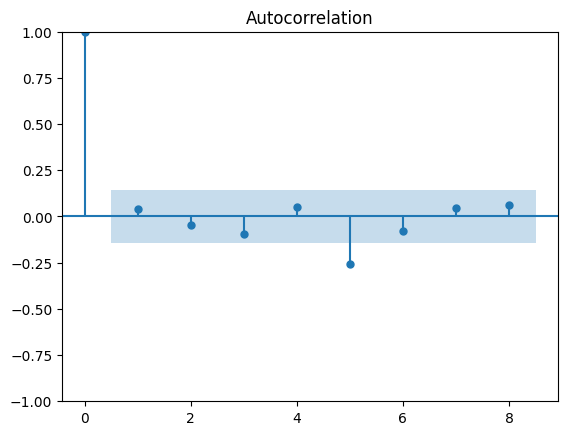

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(resid_df.resid_ARIMA_d1.dropna(), bartlett_confint=False, lags=8);


O mapa de autocorrelação mostra apenas 1 período em que poderá ter havido perda de informação.

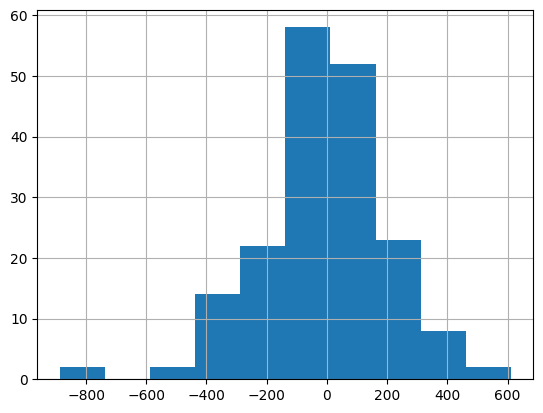

In [ ]:

resid_df.resid_ARIMA_d1.dropna().hist();

**Por fim o histograma, realmente permite-nos entender que uma maior parte dos resíduos se concentra pelos zeros.**

# _4. Previsão para o dia seguinte

> **Tarefa 2:** Fazer a previsão apenas para o dia `2021-12-01`, usando o melhor método, **escolhido com base nas melhores práticas**, entre:
* um elementar (escolher mesmo só um método elementar para testar), 
* um ETS (em versão de seleção automática) e
* um ARIMA (em versão de seleção automática).

- Horizonte fixo e origens diferentes

### **1- Treinar o modelo**

**Para esta tarefa pretendemos então fazer VÁRIAS previsões para o mesmo horizonte (h=1)**

In [ ]:
model_list2 = [SeasonalNaive(season_length=7, alias = 'SN'), 
              AutoARIMA(season_length=7, trace = True, alias = 'autoARIMA'),
              AutoARIMA(season_length=7, d=1, trace = True, alias = 'ARIMA_d1'),
              AutoETS(season_length=7, alias='AutoETS'),
              AutoETS(season_length=7, model='ZAA', damped=True,alias='ZAdA') 
              ]

sf2 = StatsForecast(df=Y_df, models=model_list2, freq='D')


**NOTA: Utilizámos outros modelos que acabámos por excluir pois não apresentavam valor ao trabalho**

In [ ]:
forecasts_df_2 = sf2.forecast(h=1,level=[90])


ARIMA(2,0,2)(1,1,1)[7]                   :2410.0678558677537

ARIMA(0,0,0)(0,1,0)[7]                   :2520.2707373531894

ARIMA(1,0,0)(1,1,0)[7]                   :2444.6449809509504

ARIMA(0,0,1)(0,1,1)[7]                   :2441.239654949846

ARIMA(2,0,2)(0,1,1)[7]                   :2411.1024776846025

ARIMA(2,0,2)(1,1,0)[7]                   :2440.9707309239984

ARIMA(2,0,2)(2,1,1)[7]                   :2412.3060027921024

ARIMA(2,0,2)(1,1,2)[7]                   :2413.0653566394863

ARIMA(2,0,2)(0,1,0)[7]                   :2474.6090332656536

ARIMA(2,0,2)(0,1,2)[7]                   :2411.6166667693824

ARIMA(2,0,2)(2,1,0)[7]                   :2435.1497815856374

ARIMA(2,0,2)(2,1,2)[7]                   :2414.028439685322

ARIMA(1,0,2)(1,1,1)[7]                   :2418.0874661463213

ARIMA(2,0,1)(1,1,1)[7]                   :2410.4880059178704

ARIMA(3,0,2)(1,1,1)[7]                   :2412.122566271308

ARIMA(2,0,3)(1,1,1)[7]                   :2412.3150351066492

ARIMA(1,0,

In [ ]:
display(forecasts_df_2)

,ds,SN,SN-lo-90,SN-hi-90,autoARIMA,autoARIMA-lo-90,autoARIMA-hi-90,ARIMA_d1,ARIMA_d1-lo-90,ARIMA_d1-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90,ZAdA,ZAdA-lo-90,ZAdA-hi-90
unique_id,,,,,,,,,,,,,,,,
KRE,2021-12-01,709.0,200.656464,1217.343506,565.868225,206.171021,925.565491,484.036621,119.597252,848.476013,496.426056,144.718521,848.133606,495.044617,139.495667,850.593567


### **2-Avaliar a performance do modelo** (Cross-validation)

In [ ]:
crossvalidation_df_2 = sf2.cross_validation(
    df = Y_df,         
    h = 1,               
    n_windows = 5      
  )
crossvalidation_df_2


ARIMA(2,0,2)(1,1,1)[7]                   :2344.1066460082898

ARIMA(0,0,0)(0,1,0)[7]                   :2450.40457068605

ARIMA(1,0,0)(1,1,0)[7]                   :2377.777907497677

ARIMA(0,0,1)(0,1,1)[7]                   :2371.725612261135

ARIMA(2,0,2)(0,1,1)[7]                   :2344.9330806665916

ARIMA(2,0,2)(1,1,0)[7]                   :2374.456685659964

ARIMA(2,0,2)(2,1,1)[7]                   :2345.921399939392

ARIMA(2,0,2)(1,1,2)[7]                   :2347.1444876143983

ARIMA(2,0,2)(0,1,0)[7]                   :2407.008576536025

ARIMA(2,0,2)(0,1,2)[7]                   :2345.443068494269

ARIMA(2,0,2)(2,1,0)[7]                   :2368.7977471718555

ARIMA(2,0,2)(2,1,2)[7]                   :2347.7096457167463

ARIMA(1,0,2)(1,1,1)[7]                   :2350.0450440384043

ARIMA(2,0,1)(1,1,1)[7]                   :2344.3373331129687

ARIMA(3,0,2)(1,1,1)[7]                   :2346.4948947985986

ARIMA(2,0,3)(1,1,1)[7]                   :2346.105987883146

ARIMA(1,0,1)(1,1

,ds,cutoff,y,SN,autoARIMA,ARIMA_d1,AutoETS,ZAdA
unique_id,,,,,,,,
KRE,2021-11-26,2021-11-25,518.0,818.0,698.589966,651.864929,654.829956,655.617371
KRE,2021-11-27,2021-11-26,263.0,359.0,314.528748,281.671600,312.353729,310.191589
KRE,2021-11-28,2021-11-27,129.0,328.0,273.343323,200.365631,160.294083,161.909317
KRE,2021-11-29,2021-11-28,501.0,617.0,588.325256,536.318237,615.412781,616.276001
KRE,2021-11-30,2021-11-29,372.0,779.0,669.350708,588.096375,612.577393,615.814758


### **Avaliar a perfomance utilizando métricas de erros comuns**( RMSE , MAE , MAPE)

In [ ]:
ts = crossvalidation_df_2.y
f1 = crossvalidation_df_2.SN
f2 = crossvalidation_df_2.autoARIMA
f3 = crossvalidation_df_2.ARIMA_d1
f4 = crossvalidation_df_2.AutoETS
f5 = crossvalidation_df_2.ZAdA

eval = pd.DataFrame({
    'rmse': [rmse(ts,f1), rmse(ts,f2),rmse(ts,f3),rmse(ts,f4),rmse(ts,f5)],
    'mae': [mae(ts,f1), mae(ts,f2),mae(ts,f3),mae(ts,f4),mae(ts,f5)],
    'mape': [mape(ts,f1), mape(ts,f2), mape(ts,f3), mape(ts,f4), mape(ts,f5)]
}, index=crossvalidation_df_2.columns[3:])
eval

,rmse,mae,mape
SN,252.159470,223.600006,76.248562
autoARIMA,174.439728,152.227600,52.742565
ARIMA_d1,119.420708,95.063354,30.680856
AutoETS,136.459015,114.493591,31.389585
ZAdA,137.828018,115.361801,31.714502


Como é possivel verificar pela tabela anterior o modelo "Arima_d1" é o que apresenta valores mais baixos de erros logo será escolhido como modelo para previsão.

### **3- Ajustar o modelo**

In [ ]:
arima_d1 =[AutoARIMA(season_length=7, d=1, trace = True, alias = 'ARIMA_d1')]

arima_d1_sf2 = StatsForecast(df=Y_df, models=arima_d1, freq='D')

In [ ]:
forecasts_arima_d1 = arima_d1_sf2.forecast(h=1,fitted=True)

forecasts_arima_d1


ARIMA(2,1,2)(1,1,1)[7]                   :2411.466460246786

ARIMA(0,1,0)(0,1,0)[7]                   :2509.8535294053313

ARIMA(1,1,0)(1,1,0)[7]                   :2444.7660756925115

ARIMA(0,1,1)(0,1,1)[7]                   :2402.8979795855194

ARIMA(0,1,1)(0,1,0)[7]                   :2476.7618641014933

ARIMA(0,1,1)(1,1,1)[7]                   :2401.1987128227656

ARIMA(0,1,1)(1,1,0)[7]                   :2440.497375959708

ARIMA(0,1,1)(2,1,1)[7]                   :2405.216506401524

ARIMA(0,1,1)(1,1,2)[7]                   :2402.600156344108

ARIMA(0,1,1)(0,1,2)[7]                   :2404.0130191278954

ARIMA(0,1,1)(2,1,0)[7]                   :2431.428352824357

ARIMA(0,1,1)(2,1,2)[7]                   :2406.067804651629

ARIMA(0,1,0)(1,1,1)[7]                   :2434.6459849711305

ARIMA(1,1,1)(1,1,1)[7]                   :2402.015049498337

ARIMA(0,1,2)(1,1,1)[7]                   :2401.4597662428573

ARIMA(1,1,0)(1,1,1)[7]                   :2410.4053949143345

ARIMA(1,1,2)(1

,ds,ARIMA_d1
unique_id,,
KRE,2021-12-01,484.036621


In [ ]:
sf.plot(Y_df, forecasts_arima_d1)

In [ ]:
insample_df2 =  arima_d1_sf2.forecast_fitted_values()
insample_df2


,ds,y,ARIMA_d1
unique_id,,,
KRE,2021-06-01,1125.0,1124.350464
KRE,2021-06-02,1177.0,1176.669189
KRE,2021-06-03,829.0,829.077576
KRE,2021-06-04,703.0,703.168945
KRE,2021-06-05,648.0,648.184509
...,...,...,...
KRE,2021-11-26,518.0,651.334900
KRE,2021-11-27,263.0,280.850311
KRE,2021-11-28,129.0,200.109268


In [ ]:
sf.plot(insample_df2)

**Os resultados foram bastante semelhantes aos da tarefa anterior, nota-se que a maior diferença reside no facto que deste vez estamos a prever para 1 horizonte utilizando várias previsões distintas**

**NOTA: Não se realizou uma análise aos resíduos visto que estes são iguais aos do modelo da tarefa acima.**